# Holographic optical field recovery using a physics-enhanced network
## Xiao Wang
## University of Arizona
## December 2022
### xwang3@arizona.edu

# load packages and modules

In [3]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as TF
import torch.optim as optim
import math
from torchinfo import summary
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob
import sys
from PIL import Image

from Pytorch_UNet.unet.unet_parts import *

import numpy as np
import cv2 as cv
plt.style.use('default')
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams.update({'font.size': 18})

from fringe.utils.io import import_image
from fringe.utils.modifiers import ImageToArray, Normalize, MakeComplex
from fringe.solvers.AngularSpectrum import AngularSpectrumSolver as AsSolver

from scipy.integrate import simpson
import IPython.display as Idisplay

2023-01-05 13:31:17.997866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 13:31:18.046672: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Build U-Net architecture by PyTorch

![U-Net architecture](unet.png)

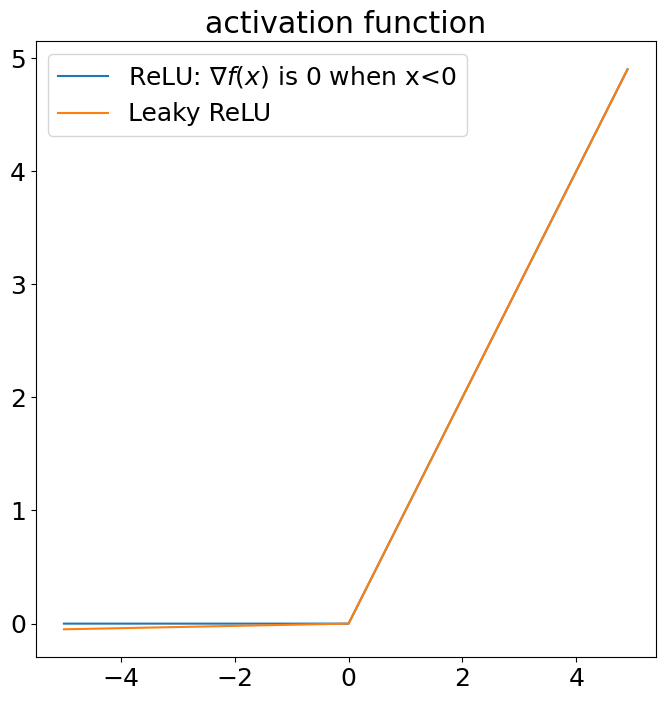

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

def relu(x):
    return np.maximum(0,x)
def Leaky_relu(x):
    return np.maximum(0.01*x,x)

x=np.arange(-5.0,5.0,0.1)
plt.plot(x, relu(x), label=r'ReLU: $\nabla f(x)$ is 0 when x<0')
plt.plot(x, Leaky_relu(x), label='Leaky ReLU')
plt.legend()
plt.title('activation function')
plt.show()

In [5]:
class UNet(nn.Module):
    def __init__(self, input_channels, output_channels, bilinear=False):
        super(UNet, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.bilinear = bilinear

        self.inc = DoubleConv(input_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 32, bilinear)
        self.outc = OutConv(32, output_channels)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        output = self.outc(x)
        return output

In [6]:
## xavier initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)

In [7]:
def test():
    x = torch.randn((1, 1, 512, 512)).to(device='cpu', dtype=torch.float32)
    model = UNet(input_channels=1, output_channels=1)
    model = model.to(device='cpu', dtype=torch.float32)
    model.apply(init_weights)
    preds = model(x)
#     torch.save(model, 'test.pt')
    print('input:', x.shape)
    print('output:', preds.shape)
    print()
    print(summary(model, input_size=(1, 1, 512, 512), device='cpu'))

## NN layers

In [8]:
test()

input: torch.Size([1, 1, 512, 512])
output: torch.Size([1, 1, 512, 512])

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 1, 512, 512]          --
├─DoubleConv: 1-1                             [1, 16, 512, 512]         --
│    └─Sequential: 2-1                        [1, 16, 512, 512]         --
│    │    └─Conv2d: 3-1                       [1, 16, 512, 512]         144
│    │    └─BatchNorm2d: 3-2                  [1, 16, 512, 512]         32
│    │    └─LeakyReLU: 3-3                    [1, 16, 512, 512]         --
│    │    └─Conv2d: 3-4                       [1, 16, 512, 512]         2,304
│    │    └─BatchNorm2d: 3-5                  [1, 16, 512, 512]         32
│    │    └─LeakyReLU: 3-6                    [1, 16, 512, 512]         --
├─Down: 1-2                                   [1, 32, 256, 256]         --
│    └─Sequential: 2-2                        [1, 32, 256, 256]         --
│    │    └─MaxPo

# build 2D and 3D forward model

## 2D

scattered wave-field $E(x,y; \Delta z=d)$ is

$$
E(x,y;\Delta z=d)=h(x,y;\Delta z=d)\otimes o(x,y,z_{\rm object})
$$
where $\Delta z= z_{\rm sensor} - z_{\rm object}$, is the propagation distance   
object field is $o(x,y,z_{\rm object})$   
PSF is $h(x,y;\Delta z=d)$

At **the sensor plane**, holgram is the interference of unscattered plane wave-field $A$ and the scattered wave-field $E(x,y;\Delta z=d)$ 
  
$$\begin{aligned} 
I(x,y;z_{\rm sensor}) &=|A+E(x,y;\Delta z=d)|^2 \\ &=|A|^2+|E(x,y;\Delta z=d)|^2+A^* E(x,y;\Delta z=d)+A E^*(x,y;\Delta z=d) 
\end{aligned}$$
  
when $|E(x,y;\Delta z=d)|^2\ll|A|^2$  
we assume $|A|=10$ and $|E(x,y;\Delta z=d)| \in [0,1]$  
  
$$\begin{aligned} 
I(x,y;z_{\rm sensor}) & \approx|A|^2+A^* E(x,y;\Delta z=d)+\left(A^* E(x,y;\Delta z=d)\right)^* \\ &=\operatorname{Re}\left[|A|^2\right]+2 \operatorname{Re}\left[A^* E(x,y;\Delta z=d)\right] \\ &=\operatorname{Re}\left[|A|^2+2 A^* E(x,y;\Delta z=d)\right] 
\end{aligned}$$

## 3D

we assume there is no secondary or mulitple scatter

$$\begin{aligned}
E(x,y; z_{\rm sensor})&=\int h(x,y,z_{\rm sensor}-z_{\rm object})\otimes o(x,y,z_{\rm object})\ {\rm d}z_{\rm object}\\
&=\sum_{i=1}^{N}h(x,y,z_{\rm sensor}-z_{{\rm object}, i})\otimes o(x,y,z_{{\rm object}, i})\\
&=\sum_{i=1}^{N}h(x,y,\Delta z_i)\otimes o(x,y,z_{{\rm object}, i})
\end{aligned}$$

when $|E(x,y; z_{\rm sensor})|^2\ll|A|^2$
$$
\begin{aligned}
I(x,y; z_{\rm sensor}) &=\left| A+E(x,y; z_{\rm sensor})\right|^2\\
&\approx\operatorname{Re}\left[|A|^2+2 A^* E(x,y; z_{\rm sensor})\right] 
\end{aligned}
$$

## Beam propagation: angular spectrum method
The field $g(x,y)$ at an output plane at $z=d$ is related to the field $f(x,y)$ at the input plane $z=0$ according to 
$$
g(x,y)={\cal F}^{-1}\left \lbrace F(u,v)e^{i2\pi z\sqrt{\frac{1}{\lambda^2}-u^2-v^2}}\right \rbrace
$$

This transformation may be implemented using the discrete Fourier transform. The sampling period $\Delta$ in the input plane is determined by the bandwidth of $f(x,y)$ and the number of samples in each dimension $N=\frac{2 X}{\Delta}$ is determined by the spatial support $[-X,X]$ of $f(x,y)$. With a simple transformation, the support of the output plane after the inverse Fourier transform is also $[-X,X]$ and the sampling period remains $\Delta$. Since the support of the field tends to grow to $N \Delta +\lambda z / \Delta$, it is necessary to zero pad the input plane by this spatial extent to avoid aliasing in the simulated diffracted field.

Here we define $lam =\frac{\lambda}{\Delta_x}$.The support of the signal in Fourier space is $[-B,B]$ where $B=\frac{1}{2\Delta}=\frac{N}{4X}$. The sampling rate in Fourier space is $\Delta_u=\frac{2B}{N}=\frac{1}{N\Delta}$. Thus

\begin{align}
G(n\Delta_u,m\Delta_u)&=F(n\Delta_u,m\Delta_u)e^{i2\pi z\sqrt{\frac{1}{\lambda^2}-n^2\Delta_u^2-m^2\Delta_u^2}}\\
&=F(n\Delta_u,m\Delta_u)e^{i2\pi \frac{z}{\lambda}\sqrt{1-\frac{n^2lam^2+m^2lam^2}{N^2}}}\\
\end{align}

To evaluate the diffracted field, consider a discretely sampled field $f_{nm}$ where the support of the field in wavelenths is $\frac{X}{\lambda}=\frac{N}{2 lam}$

## system parameters
- pixel pitch = 2$\mu$m
- wavelength = 532nm
- Amplitude of illumination plane-wave = 10 A.U.

In [9]:
pixel_pitch = 2 # μm
wavelength = 532e-3 # μm
r = 10 # illumination plane wave-field
lam = wavelength/pixel_pitch
# N is image size, e.g. 512x512 256x256

## other functions


In [10]:
def asm_custom(f, z, wavelength, pixel_pitch, only_CTF=False,
               fix_padding=False, padding=None, crop2size=False):
#
# calculate the diffracted field for the 2d image f propagated a distance d with wavelength relative to the pixel pitch lam
# d is in units of wavelengths, lam is the ratio of the wavelength to the sampling period. We assume lam<< 1
#
    d = z/wavelength
    lam = wavelength/pixel_pitch
    if lam >= 1:
        print('aliasing in the simulated diffracted field!')
#     zPad = int(np.abs(d)*lam/4)
    if fix_padding:
        zPad = padding
    else:
        zPad = int(np.abs(z)*wavelength/pixel_pitch)
        
    inF = np.zeros(np.add(f.shape, [zPad,zPad])).astype(complex)
    inF[int(inF.shape[0]/2-f.shape[0]/2):int(inF.shape[0]/2+f.shape[0]/2),
        int(inF.shape[0]/2-f.shape[0]/2):int(inF.shape[0]/2+f.shape[0]/2)] = f
#     urange = np.linspace(-lam/2,lam/2,inF.shape[0])
    urange = np.linspace(-1/(2*pixel_pitch),1/(2*pixel_pitch),inF.shape[0])
    u,v = np.meshgrid(urange, urange)
#     CTF = np.exp(1j *2* np.pi * (z/wavelength) *np.sqrt(1 - u**2 - v**2))
    CTF = np.exp(1j *2* np.pi * (d) *np.sqrt(1 - (u*wavelength)**2 - (v*wavelength)**2))
        
    if only_CTF:
        return CTF
    else:
        inf_fft = np.fft.fftshift(np.fft.fft2(inF))
        output_field = np.fft.ifft2(np.fft.ifftshift(inf_fft*CTF))
        return output_field, CTF

def asm_fringe(input_field:complex, z:float, wavelength:float, pixel_pitch:float,
               padding='same') -> 'complex output field':
    '''
    input_field:
    z: propogation distance in μm
    pixel_pitch: pixel pitch in μm
    padding 
    wavelength: wavelength in μm
    
    output_field:
    '''
    if padding != 'same':
        padding=[[[input_field.shape[0]]*2],[[input_field.shape[1]]*2]]
    # Initialize Angular Spectrum Solver
    solver = AsSolver(shape=input_field.shape, dr=pixel_pitch, is_batched=False, 
                      padding=padding, pad_fill_value=0, backend='numpy')
    output_field = solver.solve(input_=input_field, k=2 * np.pi/wavelength, z=z)
    
    return output_field

In [11]:
def holo_prop(input_field, z, r, N):
    CTF = asm_custom(input_field, z, wavelength, pixel_pitch, only_CTF=True, fix_padding=True, padding=0)
    psf = np.fft.ifft2(np.fft.ifftshift(CTF))
    x = np.linspace(-N*pixel_pitch/2, N*pixel_pitch/2, N+1)
    x = x[:-1]
    # del_x = x[1]-x[0]
    y = np.linspace(-N*pixel_pitch/2, N*pixel_pitch/2, N+1)
    y = y[:-1]
    # del_y = y[1]-y[0]
    c = simpson(simpson(psf, y), x)
    f = 1/c*(r**2) + np.conjugate(r)*input_field
    f_fft = np.fft.fftshift(np.fft.fft2(f))
    output_field = np.fft.ifft2(np.fft.ifftshift(CTF*f_fft))
    
    return output_field

In [12]:
def holo_multi_depth(input_field, z, z_pos_list, r, holo_prop, N):
    output_field = np.zeros(np.shape(input_field)).astype(complex)
    for z_pos in z_pos_list:
        output_field[..., np.where(z==z_pos)[0][0]] = holo_prop(input_field[...,np.where(z==z_pos)[0][0]],
                                                                z_pos, r, N)
        
    output_field = np.array(output_field)
    output_field = np.reshape(output_field, np.shape(input_field))
    output_field = np.sum(output_field, axis=-1)
    
    return output_field

## Forward_Model class
- initialize a Forward_Model object (tensor)
- ASM (tensor)
- hologram for 2D object (2D data, tensor)
- hologram for 3D object (3D datacube, tensor)

In [13]:
class Forward_Model(nn.Module):
    
    def __init__(self, r, N, wavelength, pixel_pitch, single_depth=True):
        super(Forward_Model, self).__init__()
        ## initialize
        self.cuda_device = "cuda" if torch.cuda.is_available() else "cpu"
#         self.input_field = torch.tensor(input_field, dtype=torch.complex64, device=self.cuda_device)
        self.wavelength = wavelength
        self.pixel_pitch = pixel_pitch
#         self.z = z
        self.r = r
        self.N = N
#         self.z_pos_list = z_pos_list
        self.single_depth = single_depth
        if self.single_depth:
            self.multi_depth = False
        else:
            self.multi_depth = True
      
    
    def asm_custom(self, f, z_pos, only_CTF=False, fix_padding=False, padding=None, crop2size=False):
    #
    # calculate the diffracted field for the 2d image f propagated a distance d with wavelength relative to the pixel pitch lam
    # d is in units of wavelengths, lam is the ratio of the wavelength to the sampling period. We assume lam<< 1
    #
        z = z_pos
        d = z/self.wavelength
        lam = self.wavelength/self.pixel_pitch
        if lam >= 1:
            print('aliasing in the simulated diffracted field!')
    #     zPad = int(np.abs(d)*lam/4)
        if fix_padding:
            zPad = padding
        else:
            zPad = int(np.abs(z)*self.wavelength/self.pixel_pitch)

    #     urange = np.linspace(-lam/2,lam/2,inF.shape[0])
        inF = torch.zeros(tuple(np.add(f.shape[2:4],[zPad,zPad])))
        inF = torch.reshape(inF, [1,1,inF.shape[0], inF.shape[1]])
        
        urange = torch.linspace(-1/(2*self.pixel_pitch), 1/(2*self.pixel_pitch), inF.shape[2])
        u,v = torch.meshgrid(urange, urange, indexing='ij')
    #     CTF = np.exp(1j *2* np.pi * (z/wavelength) *np.sqrt(1 - u**2 - v**2))
        CTF = torch.exp(1j *2* np.pi * z *torch.sqrt(1/self.wavelength**2 - u**2 - v**2))
#         np.exp(1j *2* np.pi * z *np.sqrt(1/wavelength**2 - u**2 - v**2))
        CTF = torch.reshape(CTF, [1,1,CTF.shape[0], CTF.shape[1]])
        CTF = CTF.to(dtype=torch.complex64, device=self.cuda_device)

        if only_CTF:
            if crop2size:
                CTF = CTF[0,0,zPad//2:zPad//2+self.N, zPad//2:zPad//2+self.N]
                CTF = torch.reshape(CTF, [1,1,self.N,self.N])
            return CTF
        else:
            inF = inF.to(dtype=torch.complex64, device=self.cuda_device)
            inF[0,0,int(inF.shape[2]/2-f.shape[2]/2):int(inF.shape[2]/2+f.shape[2]/2),
                    int(inF.shape[3]/2-f.shape[3]/2):int(inF.shape[3]/2+f.shape[3]/2)] = f[0,0]
            inF_fft = torch.fft.fftshift(torch.fft.fft2(inF))
            output_field = torch.fft.ifft2(torch.fft.ifftshift(inF_fft*CTF))
            output_field = output_field.to(dtype=torch.complex64, device=self.cuda_device)
            if crop2size:
                output_field = output_field[0, 0, zPad//2:zPad//2+self.N, zPad//2:zPad//2+self.N]
                CTF = CTF[0, 0, zPad//2:zPad//2+self.N, zPad//2:zPad//2+self.N]
                CTF = torch.reshape(CTF, [1,1,self.N,self.N])
                output_field = torch.reshape(output_field, [1,1,self.N,self.N])

            return output_field, CTF
            
        
    def holo_prop(self, input_field, z_pos,
                  crop2size=False, padding_size=0, exact_form=False):
        input_field = input_field.to(device=self.cuda_device)
        output_field, CTF = self.asm_custom(input_field, z_pos, only_CTF=False,
                                            fix_padding=True, padding=padding_size, crop2size=False)
        if crop2size:
            output_field = output_field[0,0,
                                        padding_size//2:padding_size//2+self.N,
                                        padding_size//2:padding_size//2+self.N]
        output_field = torch.reshape(output_field, [1,1,self.N,self.N])
        
        if not exact_form:
            hologram = torch.real(self.r**2 + 2*np.conj(self.r)*output_field)
        else:
            hologram = torch.abs(self.r + output_field)**2
        
        hologram = hologram.to(dtype=torch.float32, device=self.cuda_device)
        return hologram
        
        
    def holo_multi_depth(self, input_field, z, z_pos_list,
                         crop2size=False, padding_size=0, exact_form=False):
        
        output_field = torch.zeros((input_field).shape, dtype=torch.complex64)
        
        for z_pos in z_pos_list:
            input_field_slice = torch.reshape(input_field[0, np.where(z==z_pos)[0][0],...], [1,1,self.N,self.N])
            output_field[0, np.where(z==z_pos)[0][0],...],_ =\
                                    self.asm_custom(input_field_slice, z_pos, only_CTF=False,
                                                    fix_padding=True, padding=padding_size, crop2size=False)

            if crop2size:
                output_field = output_field[0, np.where(z==z_pos)[0][0],
                                            padding_size//2:padding_size//2+self.N,
                                            padding_size//2:padding_size//2+self.N]
            
 
        output_field = torch.sum(output_field, axis=1)
        output_field = torch.reshape(output_field, [1,1,self.N,self.N])
        if not exact_form:
            hologram = torch.real(self.r**2 + 2*np.conj(self.r)*output_field)
        else:
            hologram = torch.abs(self.r + output_field)**2
        hologram = hologram.to(dtype=torch.float32, device=self.cuda_device)
        return hologram

# load MNIST validation dataset

In [14]:
MNIST = torchvision.datasets.MNIST(root='./', train=0, download=1)

# Metrics function

In [15]:
def psnr_ssim(img_true, preds):
    psnr_comparsion = psnr(
            image_true=img_true,
            image_test=preds,
            data_range=1.0
        )

    # structural similarity index measure
    ssim_comparsion = ssim(
        im1=img_true,
        im2=preds,
        data_range=1.0,
        gaussian_weights=True,
        sigma = 1.5,
        use_sample_covariance=False   
    )
    return psnr_comparsion,ssim_comparsion

# make GIF

In [16]:
def _sort(list,b,a):
    '''
    list: Array to be sorted.
    b: char before the number
    a: char after the number
    '''
    list.sort(key = lambda x:int(x.split(a)[0].split(b)[1]))
    return list

def make_gif(frame_folder, save_name_prefix, sort=_sort):
    img_name_list = glob.glob(f"{frame_folder}/{save_name_prefix}_*.png")
    img_name_list = sort(img_name_list, save_name_prefix+'_', '.png')
    frames = [Image.open(image) for image in img_name_list]
    frame_one = frames[0]
    name = img_name_list[0].split(frame_folder+'/')[1].split('_')[0]
    frame_one.save(f"{name}_recon.gif", format="GIF", append_images=frames,
                   save_all=True, duration=1, loop=0)

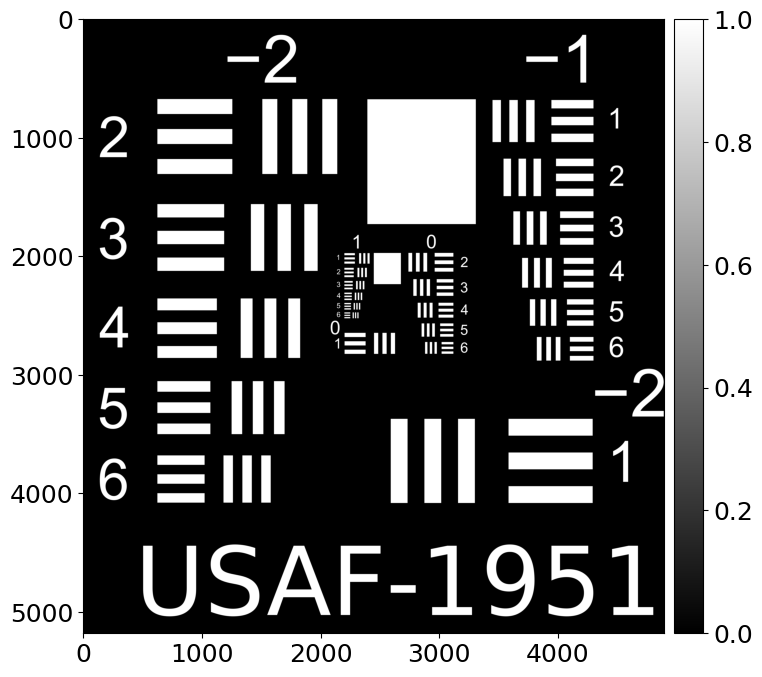

In [22]:
# name = '0821_10'
# name_index = int(name[:4])
# if name_index <= 800:
#     img_true = cv.imread('/groups/djbrady/Xiao/div2k_for_compSensing/DIV2K_train_patch/'+name+'.png', 0).astype(np.float32)
# else:
#     img_true = cv.imread('/groups/djbrady/Xiao/div2k_for_compSensing/DIV2K_valid_patch/'+name+'.png', 0).astype(np.float32)
# img_true = img_true/255.
# img_true = cv.resize(img_true, [256,256])
# img_true = img_true/np.max(img_true)
img = cv.imread('USAF-1951.png', 0).astype(np.float32)
img = 255-img
img = img/np.max(img)
im = plt.imshow(img, cmap='gray')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
plt.show()

# single-depth amplitude object

## simulated hologram at 1000$\mu$m
- object size: 512x512

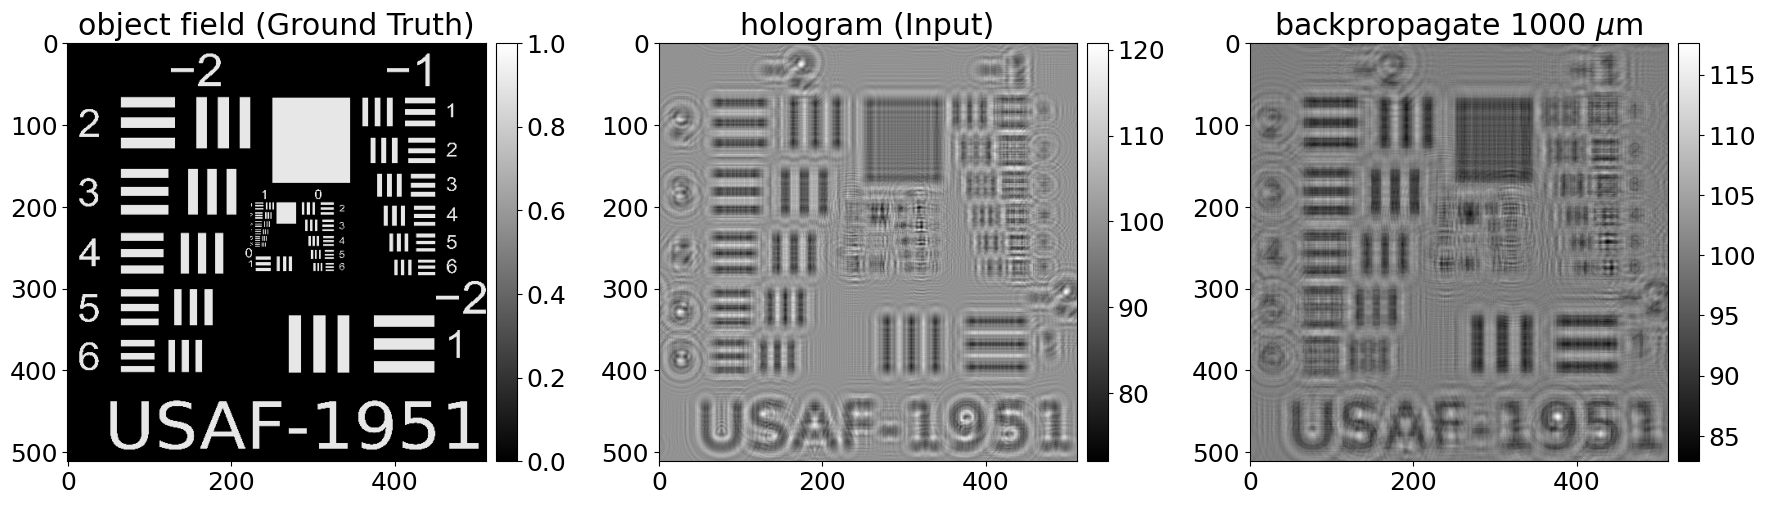

In [23]:
N = 512
z = 1000 # um
r = 10
obj_type = 2
save_name_prefix = 'testchart'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
input_field = np.zeros([1,1,N,N])

if obj_type == 0:
    index = np.random.randint(1000)
    for i in range(5):
        input_field[...,int(N/2-14)-25+25*i:int(N/2+14)-25+25*i,
                    int(N/2-14)-25+25*i:int(N/2+14)-25+25*i,] = np.array(MNIST[np.random.randint(1000)][0])/255.
    for i in range(5):
        input_field[...,int(N/2-14)-25*i+25*0:int(N/2+14)-25*i+25*0,
                    int(N/2-14)-25*i+25*2:int(N/2+14)-25*i+25*2,] = np.array(MNIST[np.random.randint(1000)][0])/255.
        input_field[...,int(N/2-14)-25*i+25*2:int(N/2+14)-25*i+25*2,
                    int(N/2-14)-25*i+25*0:int(N/2+14)-25*i+25*0,] = np.array(MNIST[np.random.randint(1000)][0])/255.
elif obj_type == 1:
    name = str(np.random.randint(1,801))
    name = (4-len(name))*'0'+name
    name += '_'+str(np.random.randint(2))+str(np.random.randint(2))
    name_index = int(name[:4])
    if name_index <= 800:
        img = cv.imread('/groups/djbrady/Xiao/div2k_for_compSensing/DIV2K_train_patch/'+name+'.png', 0).astype(np.float32)
    else:
        img = cv.imread('/groups/djbrady/Xiao/div2k_for_compSensing/DIV2K_valid_patch/'+name+'.png', 0).astype(np.float32)
    img = img/255.
    img = cv.resize(img, [N,N], interpolation=cv.INTER_CUBIC)
    img = img/np.max(img)
    input_field[0,0] = img
    save_name_prefix = 'div2k'+name[:4]
    print(save_name_prefix)
else:
    img = cv.imread('USAF-1951.png', 0).astype(np.float32)
    img = 255-img
    img = cv.resize(img, [N,N], interpolation=cv.INTER_CUBIC)
    img = img/np.max(img)
    input_field[0,0] = img


# input_field[0,0,int(N/2-14):int(N/2+14), int(N/2-14):int(N/2+14)] = np.array(MNIST[index][0])/255.
input_field = torch.tensor(input_field)
input_field = input_field.to(dtype=torch.complex64, device=DEVICE)

plt.figure(figsize=[18,6])
plt.subplot(131)
im = plt.imshow(np.abs(input_field.cpu().detach().numpy())[0,0])
plt.gray()
plt.title('object field (Ground Truth)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)

plt.subplot(132)
single_obj_holo = Forward_Model(r, N, wavelength, pixel_pitch)
hologram = single_obj_holo.holo_prop(input_field=input_field, z_pos=z, padding_size=0)
# hologram = hologram.real
# hologram = hologram/torch.max(hologram)
# print(hologram.shape)
im = plt.imshow(hologram.cpu().detach().numpy()[0,0])
plt.title('hologram (Input)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)

plt.subplot(133)
f_est, CTF = single_obj_holo.asm_custom(f=hologram, z_pos=-z, fix_padding=True, padding=0, crop2size=True)
f_est = torch.abs(f_est)
# f_est = f_est - torch.min(f_est)+0.
# f_est = f_est/torch.max(f_est)
im = plt.imshow(f_est.cpu().detach().numpy()[0,0])
plt.title(f'backpropagate {z} $\mu$m')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()

# Pipeline of Reconstruction

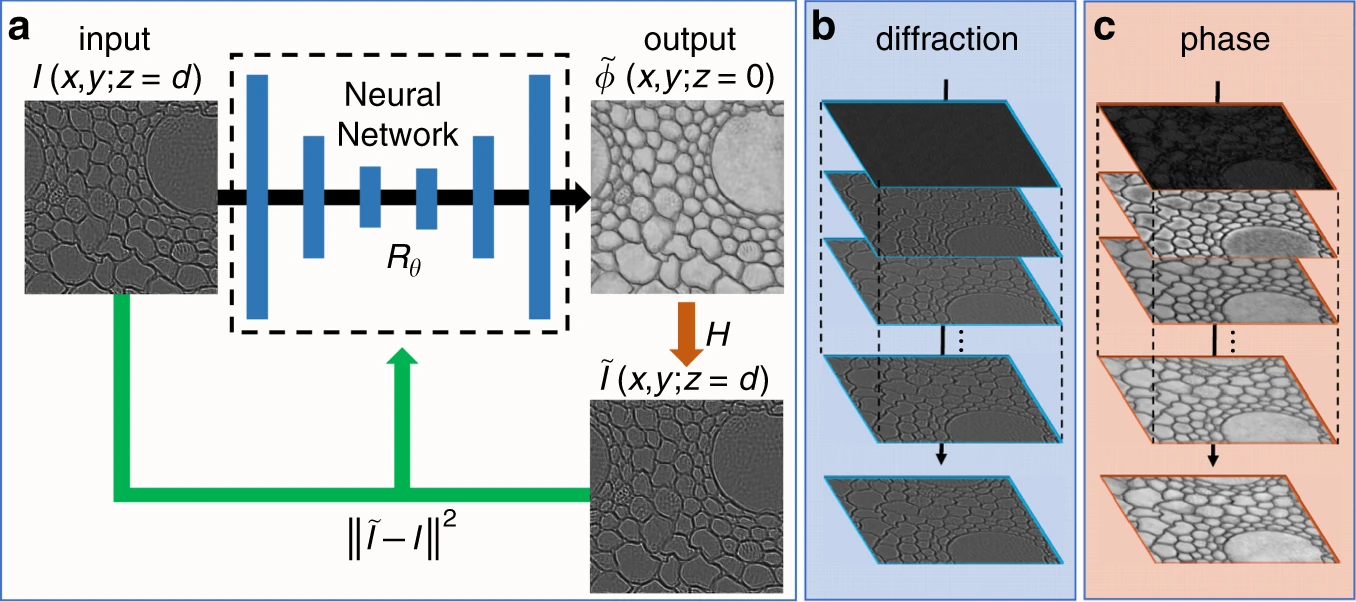

In [24]:
pipeline = Image.open('pipeline_of_PhysenNet.png')
display(pipeline)

## MSE loss function
$$
\underset{\theta \in \Theta}{\arg \min }\left\|H\left[R_\theta(I)\right]-I\right\|^2
$$

## Resconstruction
- Epoch = 20000
- Initial learning rate = 0.01
    - Decays the learning rate by 0.1 every 10000 epochs.
- Optimizer: Adam with xavier initialization
- Loss function: MSE
- Amplitude constraint: \[0, 1\]
- Only save the output corresponding to the current lowest MES loss

  0%|          | 0/20000 [00:00<?, ?it/s]

/home/dbrady/anaconda3/envs/tf/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Current learning rate: 0.01
Current lowest MSE loss = 4.2521e-02


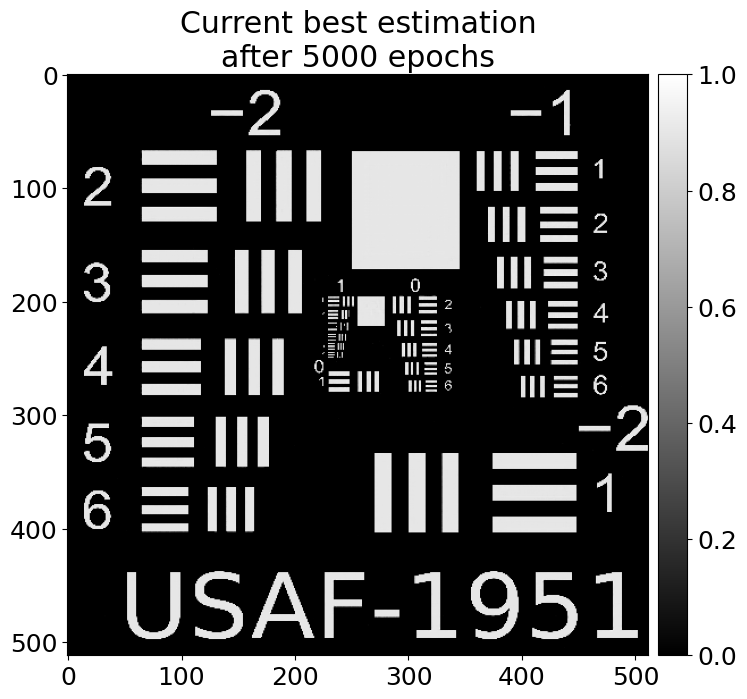

Current learning rate: 0.001
Current lowest MSE loss = 2.9848e-02


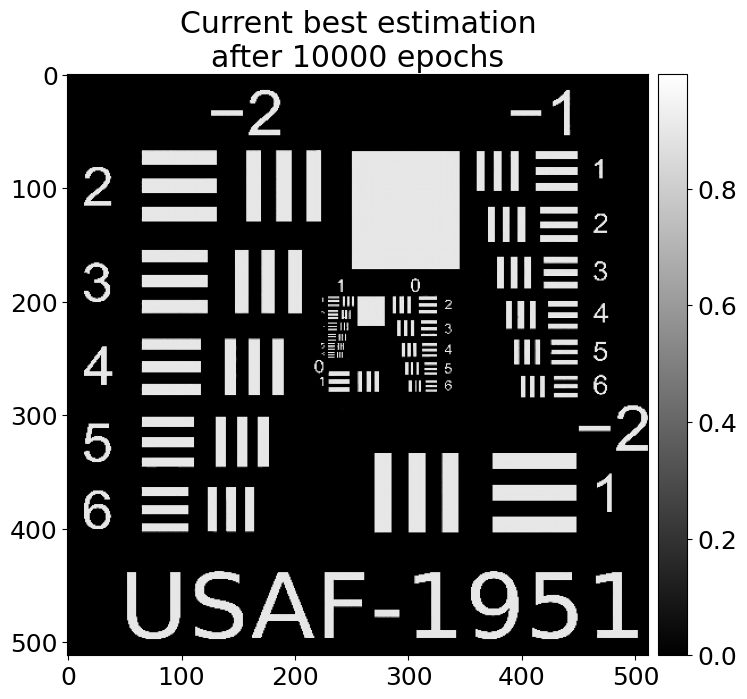

Current learning rate: 0.001
Current lowest MSE loss = 6.7721e-03


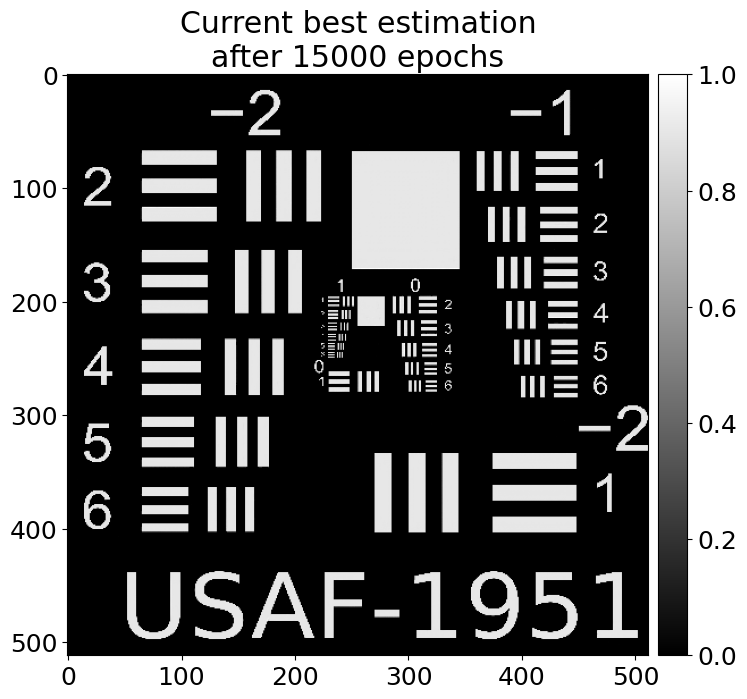

Current learning rate: 0.0001
Current lowest MSE loss = 3.0528e-03


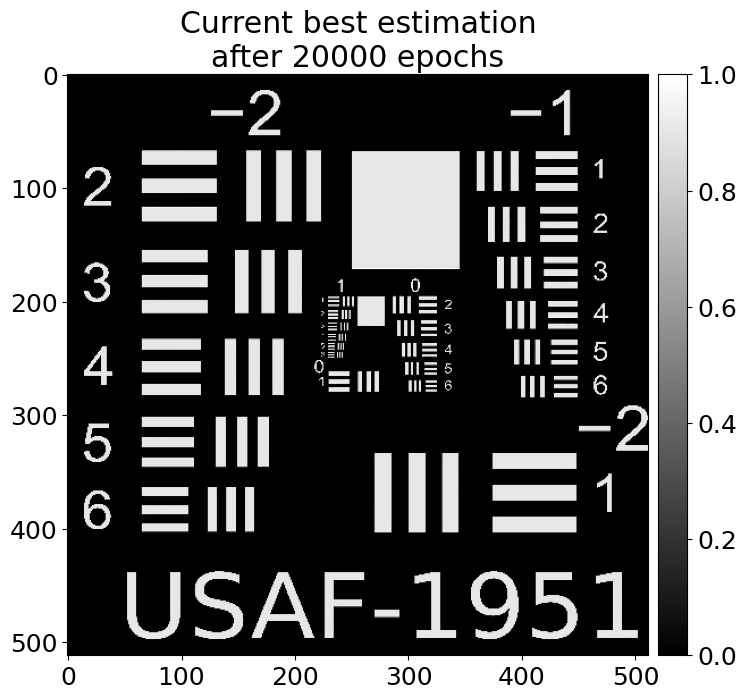

In [24]:
## Hyperparameters 
LEARNING_RATE = 0.01
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 20000
Loss_list = []

## initialize model
model = UNet(input_channels=1, output_channels=1).to(device=DEVICE, dtype=torch.float32)
model.apply(init_weights)
loss_fn = nn.MSELoss().type(torch.float32)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.1, verbose=False)
scaler = torch.cuda.amp.GradScaler()

## optimize
epoch_tqdm = tqdm(range(NUM_EPOCHS))
for num in epoch_tqdm:
    
    if num+1 == 10000:
        optimizer.param_groups[0]['weight_decay'] = 0.0001
    
    # forward
    with torch.cuda.amp.autocast():
        f_est = model(hologram).to(device=DEVICE, dtype=torch.float32)
#         f_est = torch.sigmoid(f_est)
        hologram_est = single_obj_holo.holo_prop(input_field=f_est, z_pos=z, padding_size=0)
        loss = loss_fn(hologram_est, hologram)
    
    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    
    scheduler.step()
    
    Loss_list.append(loss.cpu().detach().numpy())
    epoch_tqdm.set_postfix_str(f'Current lowest MSE loss = {np.min(Loss_list):.4e}, '+\
                               f'MSE loss = {Loss_list[-1]:.4e}')

    if np.min(Loss_list) == Loss_list[-1]:
        f_est_best = f_est.cpu().detach().numpy()[0,0]
        f_est_best[np.where(f_est_best<0)] = 0
        f_est_best[np.where(f_est_best>1)] = 1
        
    if (num+1)%500 == 0:
        cv.imwrite(f'./single_obj_recon/{save_name_prefix}_{num+1}.png', (f_est_best*255).astype(np.uint8))
        
        
    if (num+1)%5000 == 0:
        print('Current learning rate: {0}'.format(optimizer.param_groups[0]['lr']))
        print(f'Current lowest MSE loss = {np.min(Loss_list):.4e}')
        im = plt.imshow(f_est_best)
        plt.title(f'Current best estimation\nafter {num+1} epochs')
        divider = make_axes_locatable(plt.gca())
        cax = divider.append_axes("right", size="5%", pad=0.1)        
        plt.colorbar(im, cax=cax)
        plt.show()
        
    

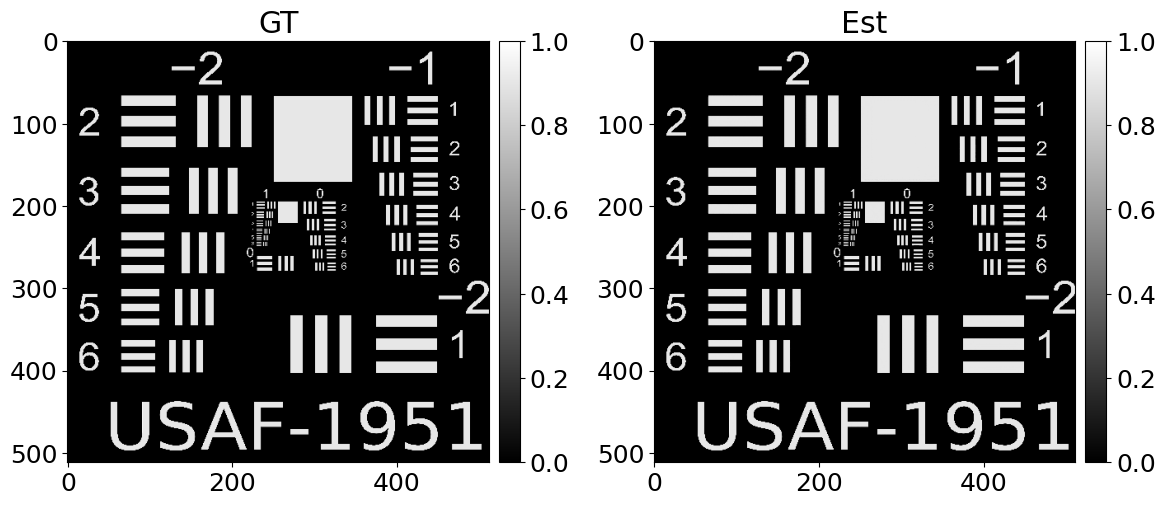

In [25]:
plt.figure(figsize=[12,6])
plt.subplot(121)
im = plt.imshow(np.abs(input_field.cpu().detach().numpy()[0,0]))
plt.title('GT')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.1)  
plt.colorbar(im, cax=cax)

plt.subplot(122)
im = plt.imshow(f_est_best)
plt.title('Est')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.1)  
plt.colorbar(im, cax=cax)
plt.tight_layout()
plt.savefig(f'{save_name_prefix}_gt_est.png', dpi=300)
plt.show()

In [37]:
gt = np.abs(input_field.cpu().detach().numpy()[0,0])
np.save(f'{save_name_prefix}_psnr_ssim.npy', psnr_ssim(gt, f_est_best))
psnr_ssim(gt, f_est_best)

(48.08067749152079, 0.9997187994065863)

In [38]:
make_gif('single_obj_recon', save_name_prefix)

## USAF testchart

### results

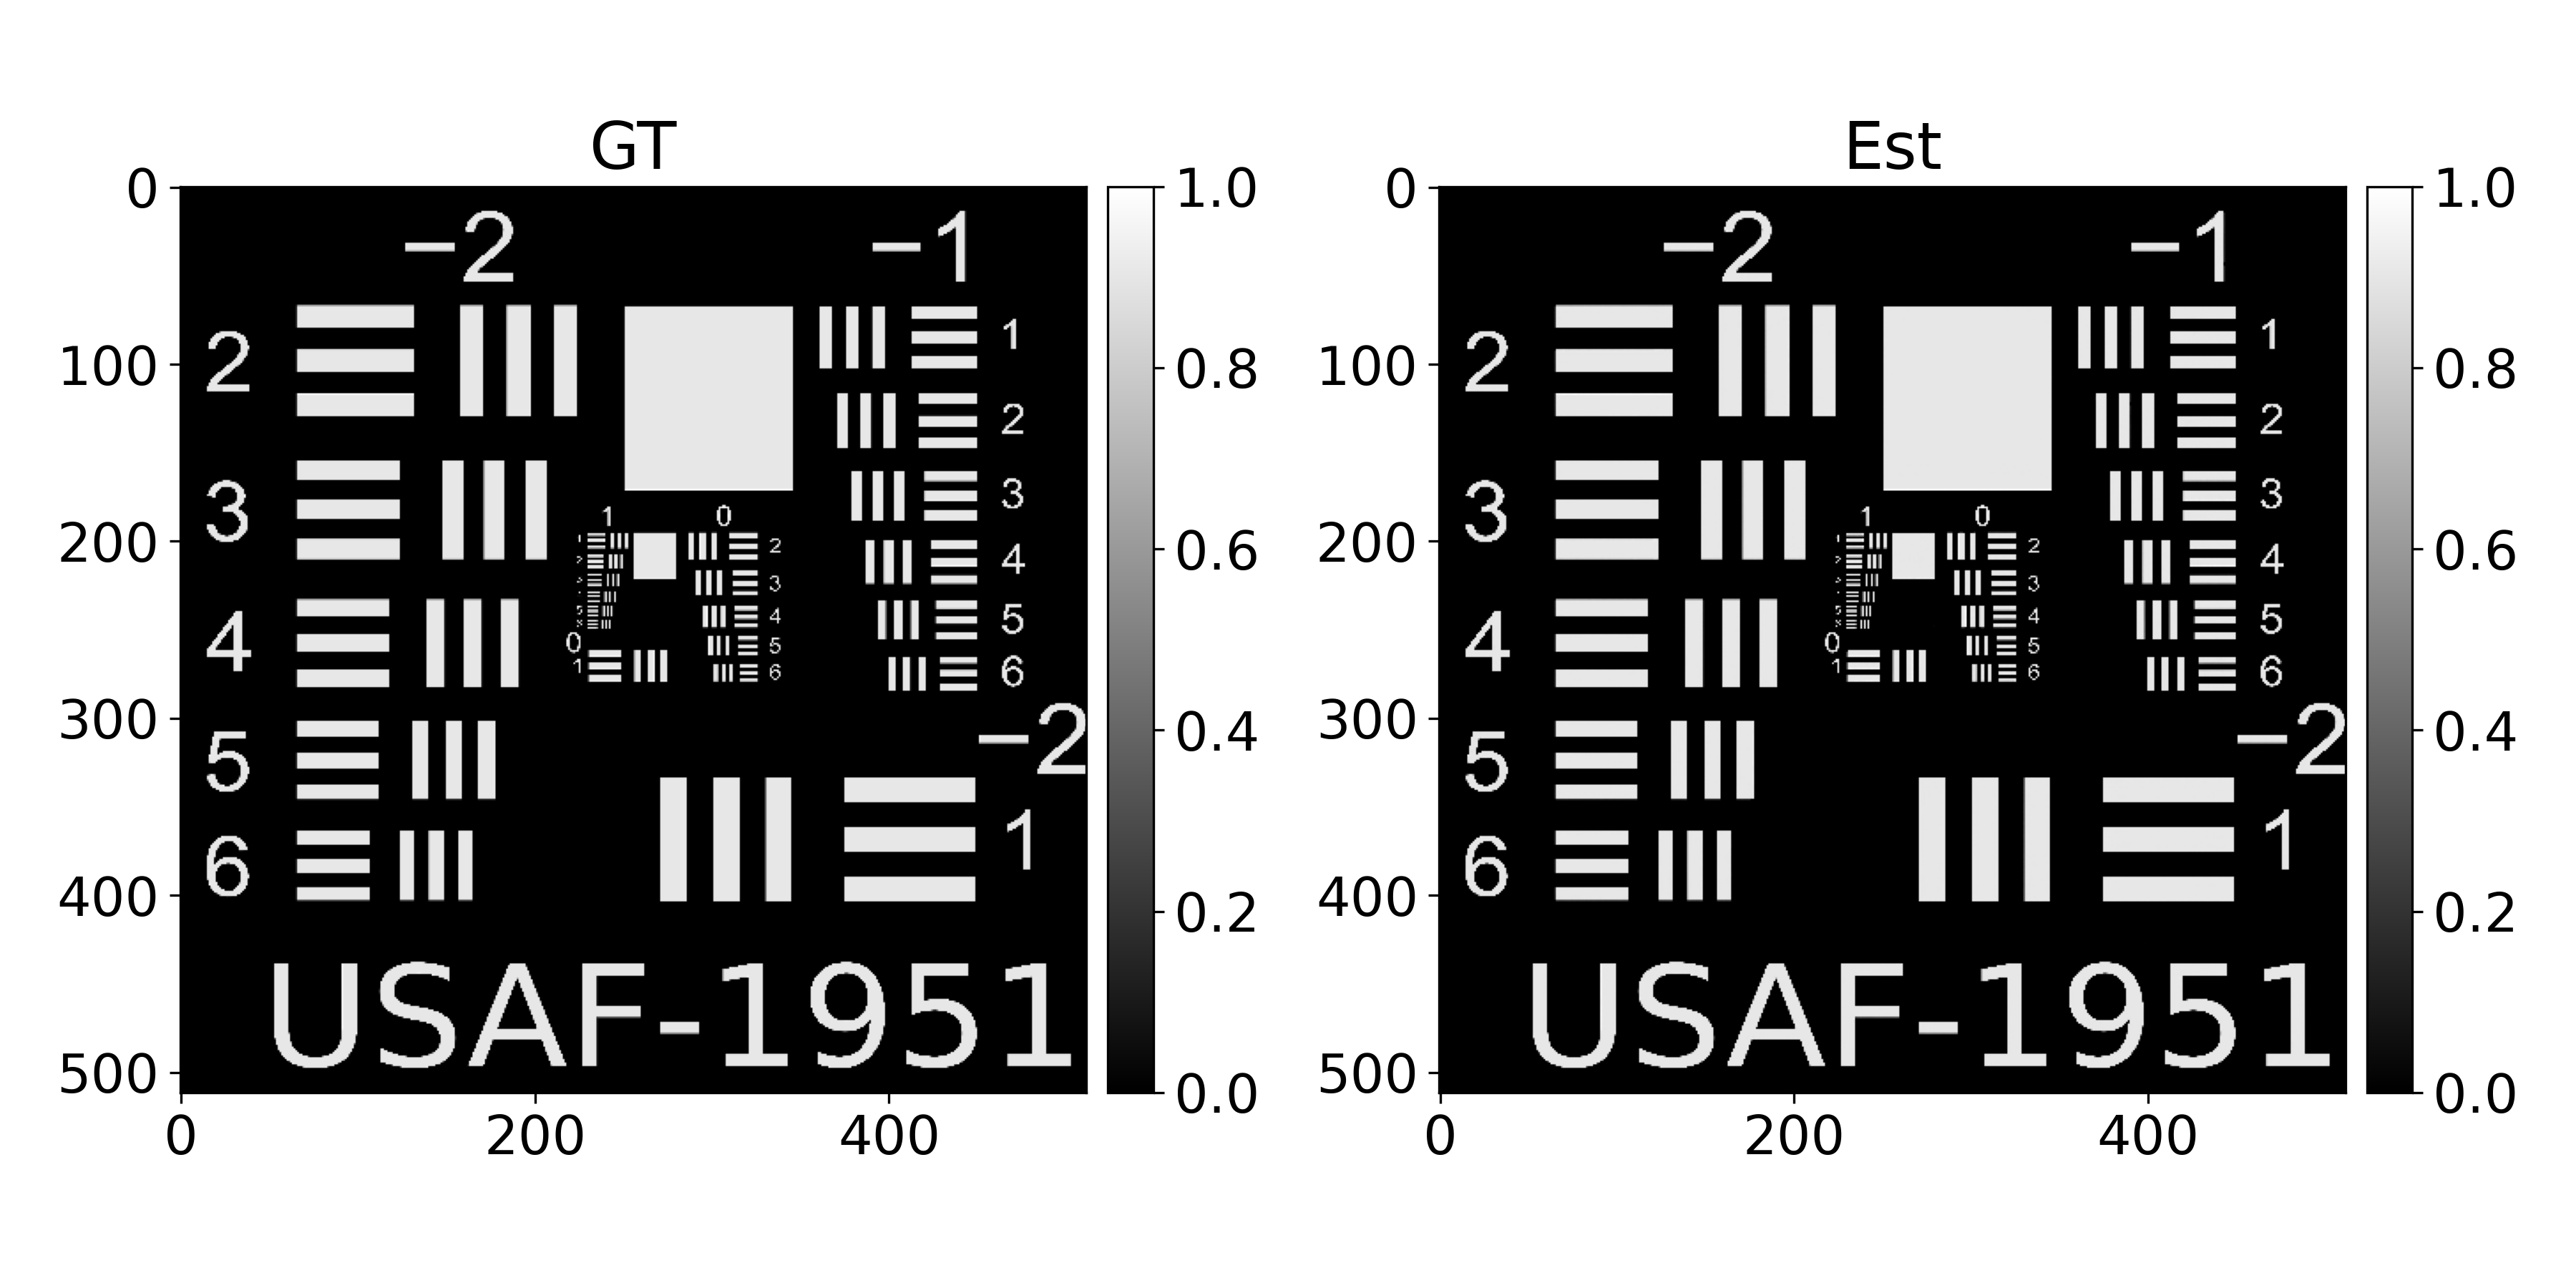

[48.08067749  0.9997188 ]


In [39]:
im = Image.open('testchart_gt_est.png')
display(im)
print(np.load('testchart_psnr_ssim.npy'))

### reconstruction procedure

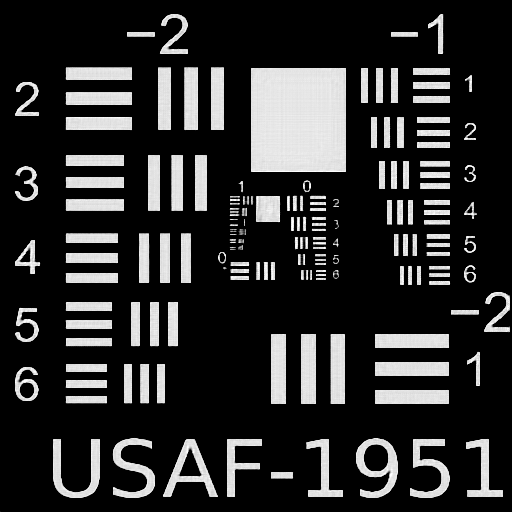

In [40]:
Idisplay.Image(open(f'{save_name_prefix}_recon.gif','rb').read(), format='PNG')

# multi-depth amplitude object 
## resconstructed with a regularized untrained NN
- size: 256x256x3 at (1000, 1250, 2000)$\mu$m

In [18]:
z_slice = 3
# z = np.linspace(500, 1900, z_slice)
z = np.arange(1000, 1500+1, 250).astype('float32')
z_pos_list = z
N = 256
r = 10
save_name_prefix = 'multidepthMnist02'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
z

array([1000., 1250., 1500.], dtype=float32)

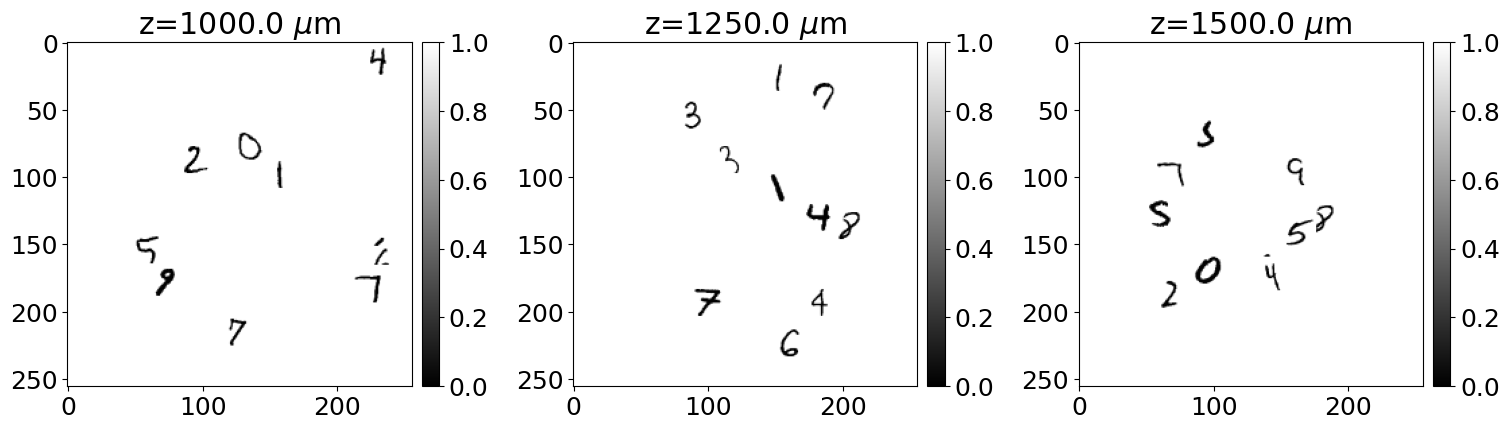

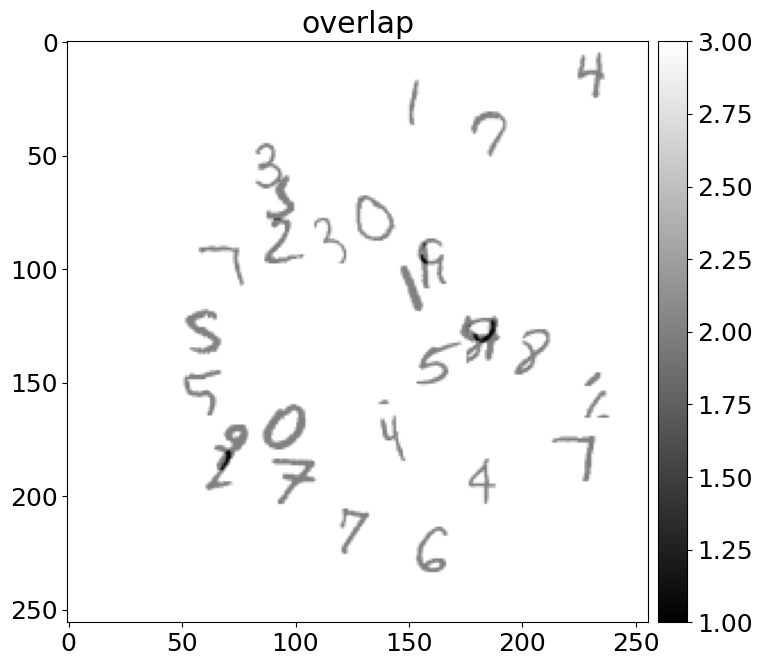

In [19]:
input_field = np.zeros([1,len(z),N,N]).astype('float32')
scale = 1
# i = 0
for z_pos in z_pos_list:
    try:
        x = np.random.randint(N//2)
        y = np.random.randint(N//2)
        letter = np.array(MNIST[np.random.randint(1000)][0]).astype(float)
        letter = cv.resize(letter, [28*scale]*2)
        letter = letter/np.max(letter)
        input_field[0, np.where(z==z_pos)[0][0],
                    x:x+28*scale, y:y+28*scale] = letter
        x = np.random.randint(N//2,N-28*scale)
        y = np.random.randint(N//2)
        letter = np.array(MNIST[np.random.randint(1000)][0]).astype(float)
        letter = cv.resize(letter, [28*scale]*2)
        letter = letter/np.max(letter)
        input_field[0, np.where(z==z_pos)[0][0],
                    x:x+28*scale, y:y+28*scale] = letter
        x = np.random.randint(N//2)
        y = np.random.randint(N//2,N-28*scale)
        letter = np.array(MNIST[np.random.randint(1000)][0]).astype(float)
        letter = cv.resize(letter, [28*scale]*2)
        letter = letter/np.max(letter)
        input_field[0, np.where(z==z_pos)[0][0],
                    x:x+28*scale, y:y+28*scale] = letter
        x = np.random.randint(N//2,N-28*scale)
        y = np.random.randint(N//2,N-28*scale)
        letter = np.array(MNIST[np.random.randint(1000)][0]).astype(float)
        letter = cv.resize(letter, [28*scale]*2)
        letter = letter/np.max(letter)
        input_field[0, np.where(z==z_pos)[0][0],
                    x:x+28*scale, y:y+28*scale] = letter
        for j in range(6):
            x = np.random.randint(N-28*scale)
            y = np.random.randint(N-28*scale)
            letter = np.array(MNIST[np.random.randint(1000)][0]).astype(float)
            letter = cv.resize(letter, [28*scale]*2)
            letter = letter/np.max(letter)
            input_field[0, np.where(z==z_pos)[0][0],
                        x:x+28*scale, y:y+28*scale] = letter
    
#     input_field[0,np.where(z==z_pos)[0][0],
#                 int(N/2-14)-64+25*i:int(N/2+14)-64+25*i,
#                 int(N/2-14)-64+25*i:int(N/2+14)-64+25*i,] = np.array(MNIST[np.random.randint(1000)][0])/255.
#     input_field[0,np.where(z==z_pos)[0][0],
#                 int(N/2-14)-32+25*i:int(N/2+14)-32+25*i,
#                 int(N/2-14)-32+25*i:int(N/2+14)-32+25*i,] = np.array(MNIST[np.random.randint(1000)][0])/255.
#     input_field[0,np.where(z==z_pos)[0][0],
#                 int(N/2-14)-0+25*i:int(N/2+14)-0+25*i,
#                 int(N/2-14)-0+25*i:int(N/2+14)-0+25*i,] = np.array(MNIST[np.random.randint(1000)][0])/255.
#         i += 1
    except:
        continue
    
input_field = 1-input_field
plt.figure(figsize=[20,10])
for i in range(len(z)):
    plt.subplot(2,4,1+i)
    im = plt.imshow(abs(input_field[0,i,...]))
    plt.title(f'z={z[i]} $\mu$m')
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.1)  
    plt.colorbar(im, cax=cax)
    plt.gray()
    
    
plt.tight_layout()
plt.show()

plt.figure()
im = plt.imshow(np.sum(abs(input_field[0,...]), axis=0))
plt.title('overlap')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.1)  
plt.colorbar(im, cax=cax)
plt.show()
input_field = torch.tensor(input_field)
input_field = input_field.to(dtype=torch.complex64, device=DEVICE)

In [20]:
padding_size = int(np.max(z)*wavelength/pixel_pitch/pixel_pitch)
padding_size

199

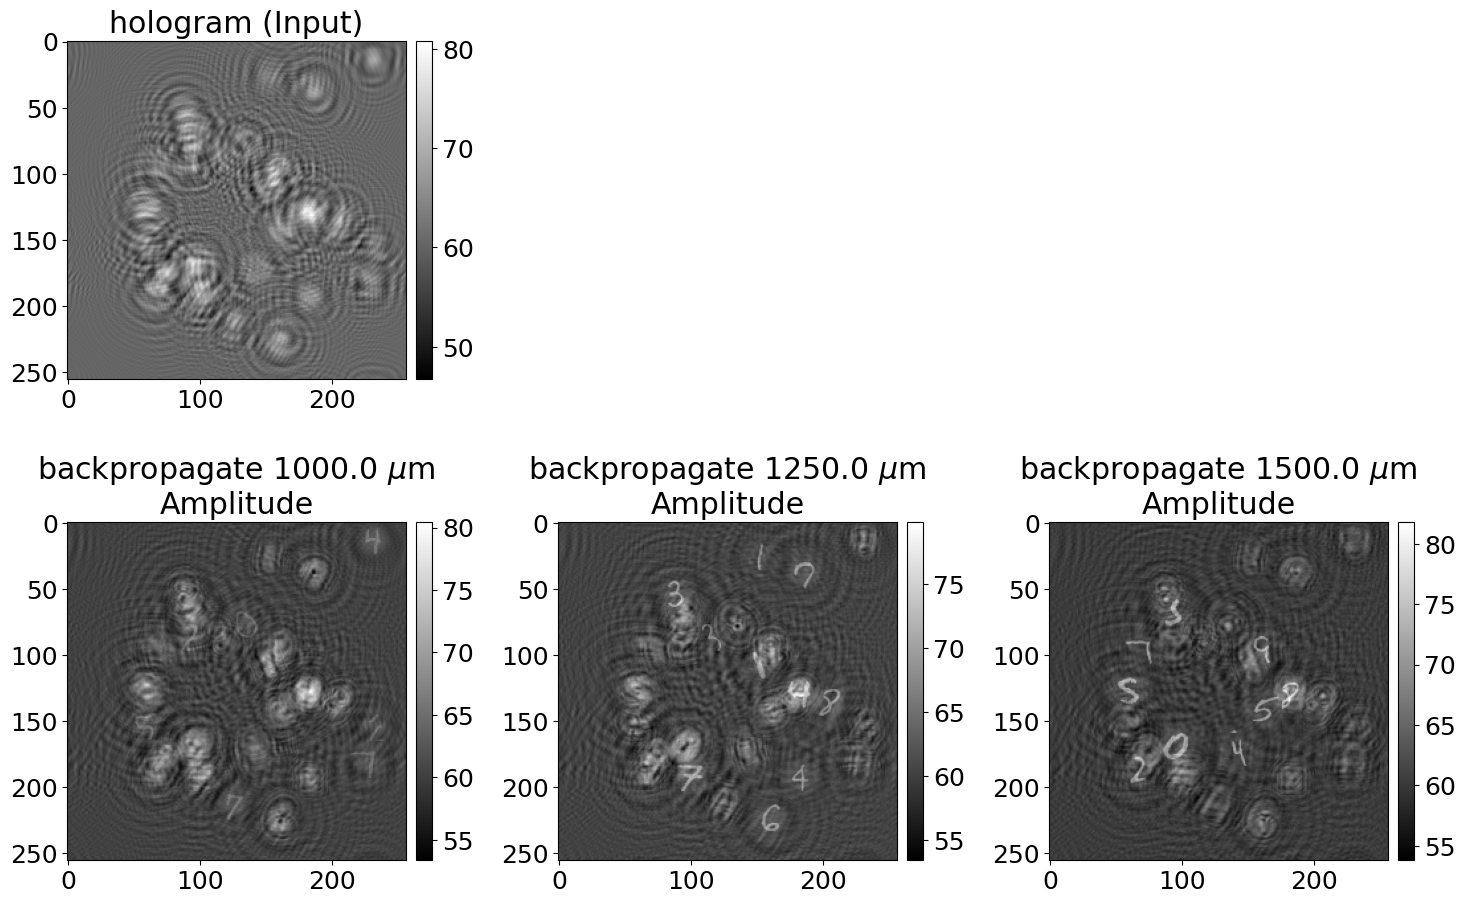

In [21]:
plt.figure(figsize=[15,14])
plt.subplot(3,3,1)
multi_obj_holo = Forward_Model(r, N, wavelength, pixel_pitch, single_depth=False)
hologram = multi_obj_holo.holo_multi_depth(input_field=input_field, z=z, z_pos_list=z, padding_size=0)
im = plt.imshow(hologram.cpu().detach().numpy()[0,0])
# plt.axis('off')
plt.gray()
plt.title('hologram (Input)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.1)  
plt.colorbar(im, cax=cax)

for i in range(len(z)):
    plt.subplot(3,3,4+i)
    f_est, CTF = multi_obj_holo.asm_custom(f=hologram, z_pos=-z[i], fix_padding=True, padding=0, crop2size=True)
    f_est = torch.abs(f_est)
#     f_est = f_est - torch.min(f_est)+0.
#     f_est = f_est/torch.max(f_est)
    im = plt.imshow(f_est.cpu().detach().numpy()[0,0])
#     plt.axis('off')
    plt.title(f'backpropagate {z[i]} $\mu$m\nAmplitude')
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()

## change LeakReLU into Sigmoid at the last layer

In [22]:
class UNet_sigmoid(nn.Module):
    def __init__(self, input_channels, output_channels, bilinear=False):
        super(UNet_sigmoid, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.bilinear = bilinear

        self.inc = DoubleConv(input_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 32, bilinear)
        self.outc = nn.Sequential(
            nn.Conv2d(32, self.output_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(self.output_channels),
            nn.Sigmoid())


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        output = self.outc(x)
        return output

In [23]:
def test():
    x = torch.randn((1, 1, 512, 512)).to(device='cpu', dtype=torch.float32)
    model = UNet_sigmoid(input_channels=1, output_channels=3)
    model = model.to(device='cpu', dtype=torch.float32)
    model.apply(init_weights)
    preds = model(x)
#     torch.save(model, 'test.pt')
    print('input:', x.shape)
    print('output:', preds.shape)
    print()
    print(summary(model, input_size=(1, 1, 512, 512), device='cpu'))

In [24]:
test()

input: torch.Size([1, 1, 512, 512])
output: torch.Size([1, 3, 512, 512])

Layer (type:depth-idx)                        Output Shape              Param #
UNet_sigmoid                                  [1, 3, 512, 512]          --
├─DoubleConv: 1-1                             [1, 16, 512, 512]         --
│    └─Sequential: 2-1                        [1, 16, 512, 512]         --
│    │    └─Conv2d: 3-1                       [1, 16, 512, 512]         144
│    │    └─BatchNorm2d: 3-2                  [1, 16, 512, 512]         32
│    │    └─LeakyReLU: 3-3                    [1, 16, 512, 512]         --
│    │    └─Conv2d: 3-4                       [1, 16, 512, 512]         2,304
│    │    └─BatchNorm2d: 3-5                  [1, 16, 512, 512]         32
│    │    └─LeakyReLU: 3-6                    [1, 16, 512, 512]         --
├─Down: 1-2                                   [1, 32, 256, 256]         --
│    └─Sequential: 2-2                        [1, 32, 256, 256]         --
│    │    └─MaxPo

## reconstruction
- Epoch = 25,000
- Initial learning rate = 0.01
- Optimizer: AdamW with xavier initialization
    - $L_2$ regulization
        - weight decay coefficient = 0.002
        - AdamW only the gradient of the loss function is adopted (others, such as Adam, will include the regularizer itself)
        - reason: Assuming the variables are small, independent, and uncorrelated, energy minimization regularization algorithms such as the $L_2$ regularization encourages the weights to become small to reduce the contribution of every non-significant component in the features space. prevent overfitting
- Loss function: MSE + $L_2$ regulization
    - $\underset{\theta \in \Theta}{\arg \min }\left\{\left\|H\left[R_\theta(I)\right]-I\right\|_2^2+\frac{\eta }{2\alpha }{\Vert {\theta}\Vert }_{2}^{2}\right\}$
- Randomization
    - **During the first 20,000 epochs, every 500 iterations**:
    > 1.A Gaussian noise tensor with a mean of 0 and a standard deviation of 0.02 should be added to the input tensor.  
    >
    > 2.The amplitude image should be multiplied by a coefficient whose value switches between 1.1 and 1.5 in every randomization step.
    - Reason: Since the loss function is non-convex, minimizing the cost may not necessarily lead to a true solution. Assuming the loss function has a global minimum, perturbing the parameters periodically could prevent overfitting on a particular set of parameters.  
- Only save the output corresponding to the current lowest loss  

Ref: Niknam, F., Qazvini, H. & Latifi, H. Holographic optical field recovery using a regularized untrained deep decoder network. Sci Rep 11, 10903 (2021). https://doi.org/10.1038/s41598-021-90312-5

In [25]:
!mkdir single_obj_recon

/bin/bash: /home/dbrady/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


  0%|          | 0/15000 [00:00<?, ?it/s]

Current model LR: 0.01
Current lowest MSE loss = 1.6705e+00


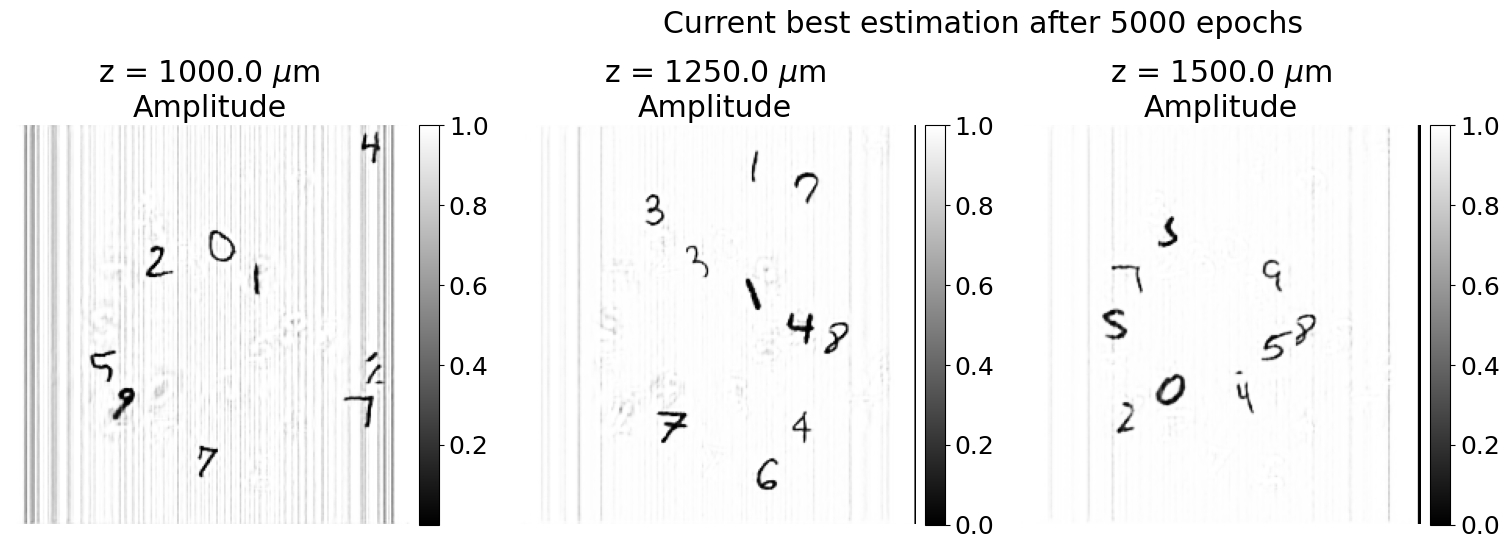

Current model LR: 0.01
Current lowest MSE loss = 8.6297e-01


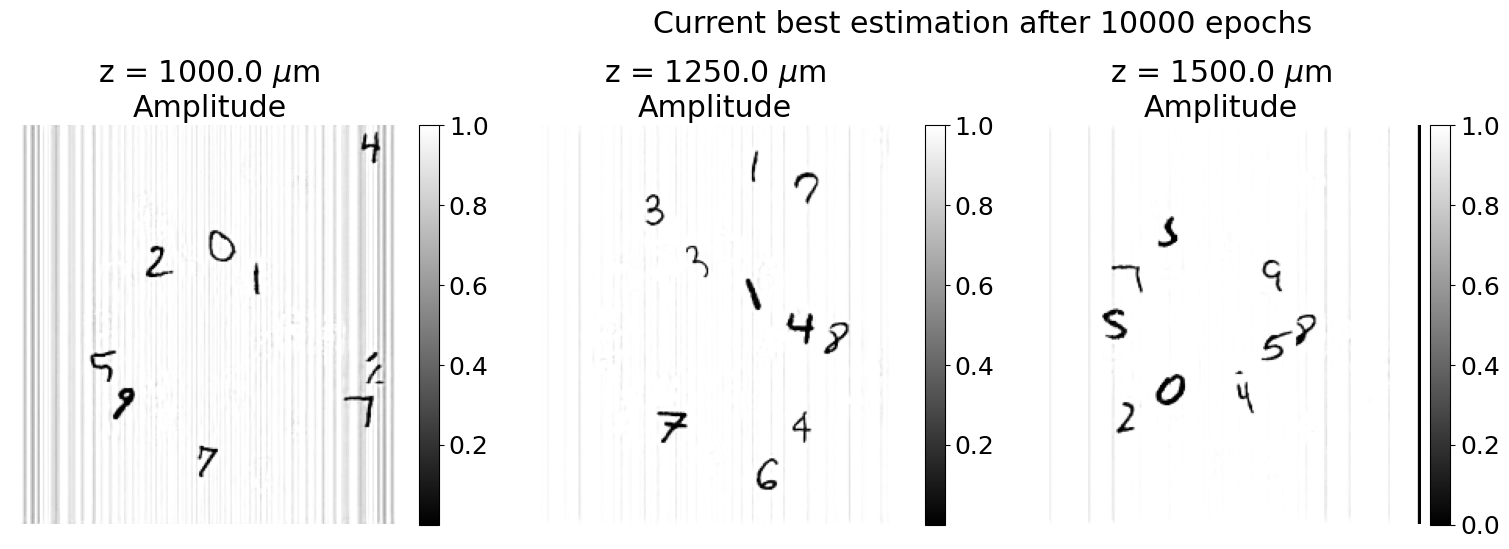

Current model LR: 0.01
Current lowest MSE loss = 2.9772e-01


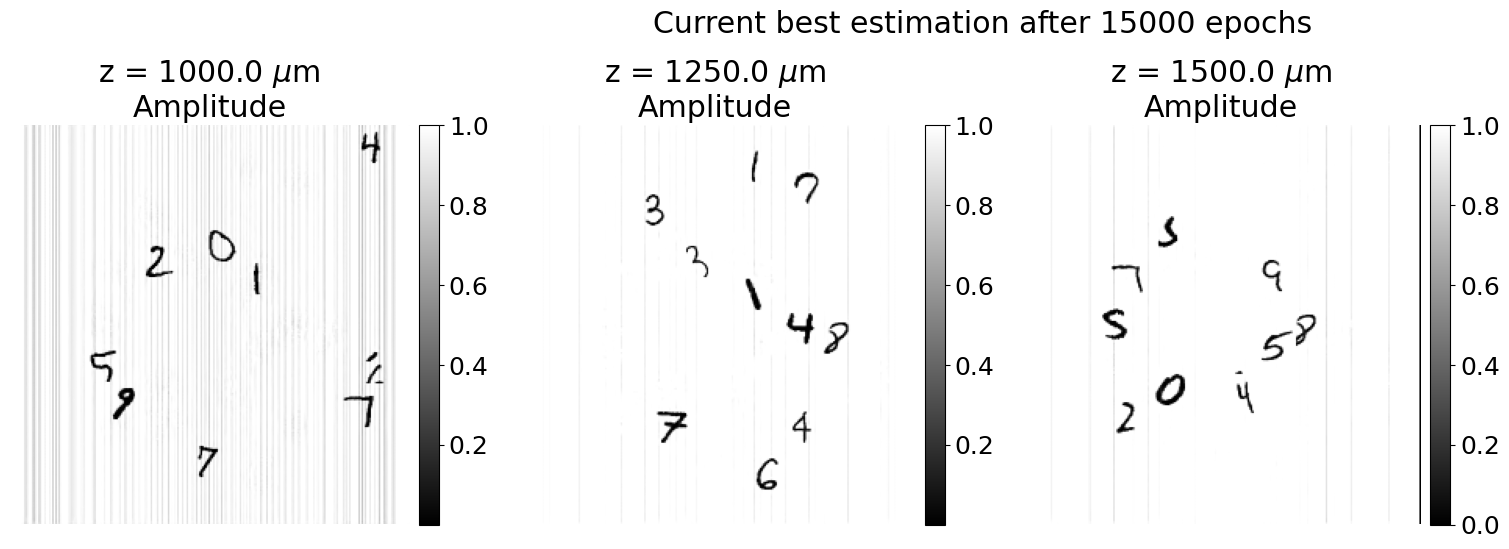

In [27]:
## Hyperparameters 
LEARNING_RATE = 1e-2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 15000
Loss_list = []

## initialize model
model = UNet_sigmoid(input_channels=1, output_channels=len(z)).to(device=DEVICE, dtype=torch.float32)
model.apply(init_weights)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.002,)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100000, gamma=1, verbose=False)

scaler = torch.cuda.amp.GradScaler()
loss_fn = nn.MSELoss().type(torch.float32)
value_count = torch.zeros([N,N]).to(device=DEVICE, dtype=torch.float32)
## optimize
epoch_tqdm = tqdm(range(NUM_EPOCHS))
hologram = hologram.to(device=DEVICE, dtype=torch.float32)

for num in epoch_tqdm:
    
    if num+1 == 10000:
        optimizer.param_groups[0]['weight_decay'] = 0.0002
    
    ## forward
    with torch.cuda.amp.autocast():
        if (num+1)%500 == 0:
            noise = torch.normal(0, 0.02, size=[1,1,N,N]).to(device=DEVICE, dtype=torch.float32)
        else:
            noise = 0
        f_est = model(hologram+noise).to(device=DEVICE)
        
        if (num+1)%500 == 0:
            amp_coef = 0.4*np.random.random()+1.1
        else:
            amp_coef = 1
        f_est = (f_est*amp_coef).to(device=DEVICE, dtype=torch.complex64)
        
        hologram_est = multi_obj_holo.holo_multi_depth(input_field=f_est, z=z,
                                                       z_pos_list=z, padding_size=0)
        loss = loss_fn(hologram_est, hologram)
    
    ## backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    scheduler.step()
    
    
    Loss_list.append(loss.cpu().detach().numpy())
    epoch_tqdm.set_postfix_str(f'Current lowest MSE loss = {np.min(Loss_list):.4e}, '+\
                               f'MSE loss = {Loss_list[-1]:.4e}')

    if np.min(Loss_list) == Loss_list[-1]:
        f_est_best = f_est.cpu().detach().numpy()[0]
        
    if (num+1)%5000 == 0:
        f_est_best_amp = np.abs(f_est_best)
        
        for i in range(len(z)):
            if i == 0:
                f_est_best_view = f_est_best_amp[0]/np.max(f_est_best_amp[0])
            else:
                f_est_best_view = np.concatenate((f_est_best_view,
                                                  f_est_best_amp[i]/np.max(f_est_best_amp[i])), axis=1)

        cv.imwrite(f'./single_obj_recon/{save_name_prefix}_{num+1}.png',
                   (f_est_best_view*255).astype(np.uint8))
    
    if (num+1)%5000 == 0:
        print('Current model LR: {0}'.format(optimizer.param_groups[0]['lr']))
#         print('Current Phase model learning rate: {0}'.format(optimizer.param_groups[0]['lr']))
        print(f'Current lowest MSE loss = {np.min(Loss_list):.4e}')
        
        plt.figure(figsize=[20,10])
        for i in range(len(z)):
            plt.subplot(2,4,i+1)
            im = plt.imshow(np.real(f_est_best[i]))
            plt.axis('off')
            plt.gray()
            plt.title(f'z = {z[i]} $\mu$m\nAmplitude')
            divider = make_axes_locatable(plt.gca())
            cax = divider.append_axes("right", size="5%", pad=0.1)
            plt.colorbar(im, cax=cax)

        plt.suptitle(f'Current best estimation after {num+1} epochs')
        plt.tight_layout()
        plt.show()
        
        
    

## procedure

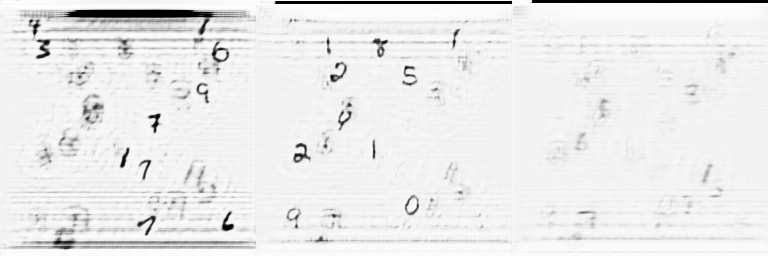

In [68]:
make_gif('single_obj_recon', save_name_prefix)
Idisplay.Image(open(f'{save_name_prefix}_recon.gif','rb').read(), format='PNG')

Weight decay regularization does not impose sparsity but **reduces the variations of the features obtained from the object**. The variation reduction occurs in the parameter space under the influence of the under-parameterization of the network which results in the extraction of **a simplified representation of the object in the feature domain**. Weight decay further penalizes the parameters to gather as few varying features as possible, thus enforces **a sparsity constraint on the feature extraction process**. Sparsity promotion in the proposed method manifests as a **smoothing effect over large spatial features** and its strength can be controlled by the weight decay coefficient. In general terms, this effect improves the overall quality of the reconstructions by **removing high-frequency noises especially the artifacts originating from other sources** than the object plane

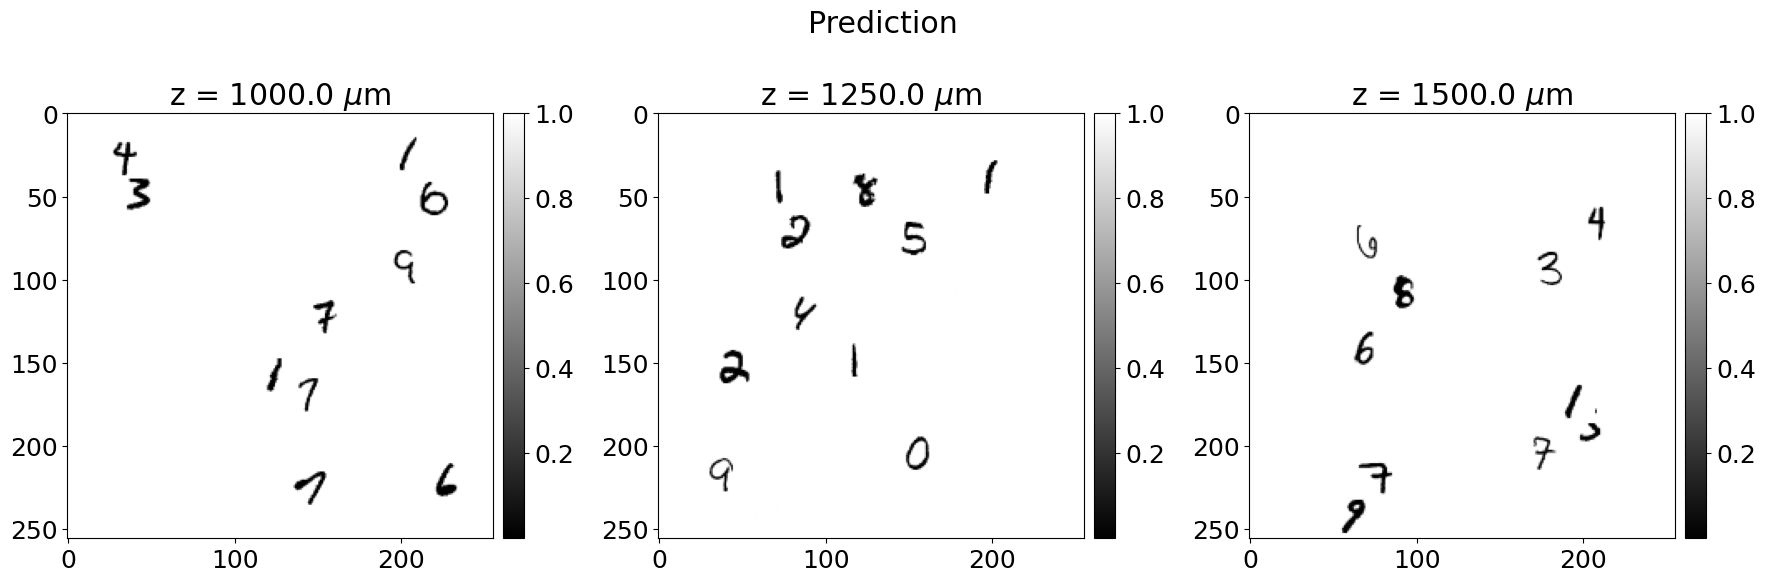

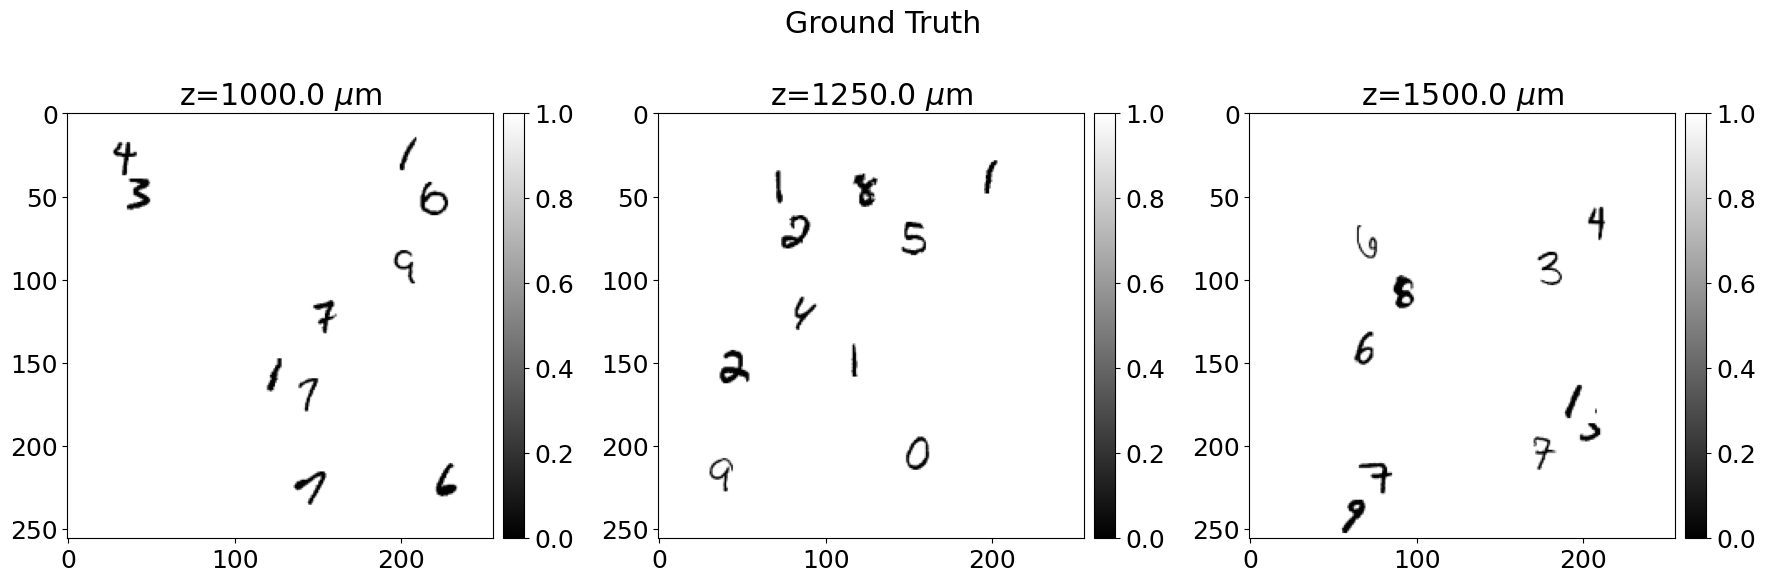

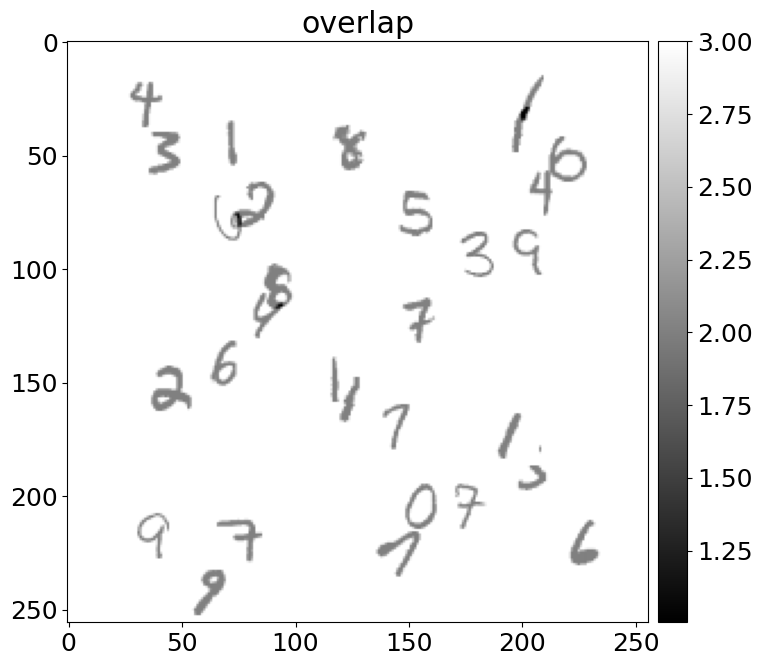

In [69]:
plt.figure(figsize=[18,6])
for i in range(len(z)):
    plt.subplot(1,3,i+1)
    im = plt.imshow(abs(f_est_best[i]))
    plt.gray()
    plt.title(f'z = {z[i]} $\mu$m')
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)
    
plt.suptitle('Prediction')
plt.tight_layout()
plt.savefig(f'{save_name_prefix}.png', dpi=300)
plt.show()

plt.figure(figsize=[18,6])
for i in range(len(z)):
    plt.subplot(1,3,1+i)
    im = plt.imshow(abs(input_field[0,i,...].cpu().detach().numpy()))
    plt.title(f'z={z[i]} $\mu$m')
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.1)  
    plt.colorbar(im, cax=cax)
    plt.gray()
plt.suptitle('Ground Truth')
plt.tight_layout()
plt.show()

plt.figure()
im = plt.imshow(np.sum(abs(input_field[0,...].cpu().detach().numpy()), axis=0))
plt.title('overlap')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.1)  
plt.colorbar(im, cax=cax)
plt.show()

## PSNR

In [278]:
psnr_comparsion = psnr(
            image_true=abs(input_field[0].cpu().detach().numpy()),
            image_test=abs(f_est_best),
            data_range=1.0
        )
psnr_comparsion

60.604827677536115

## Result

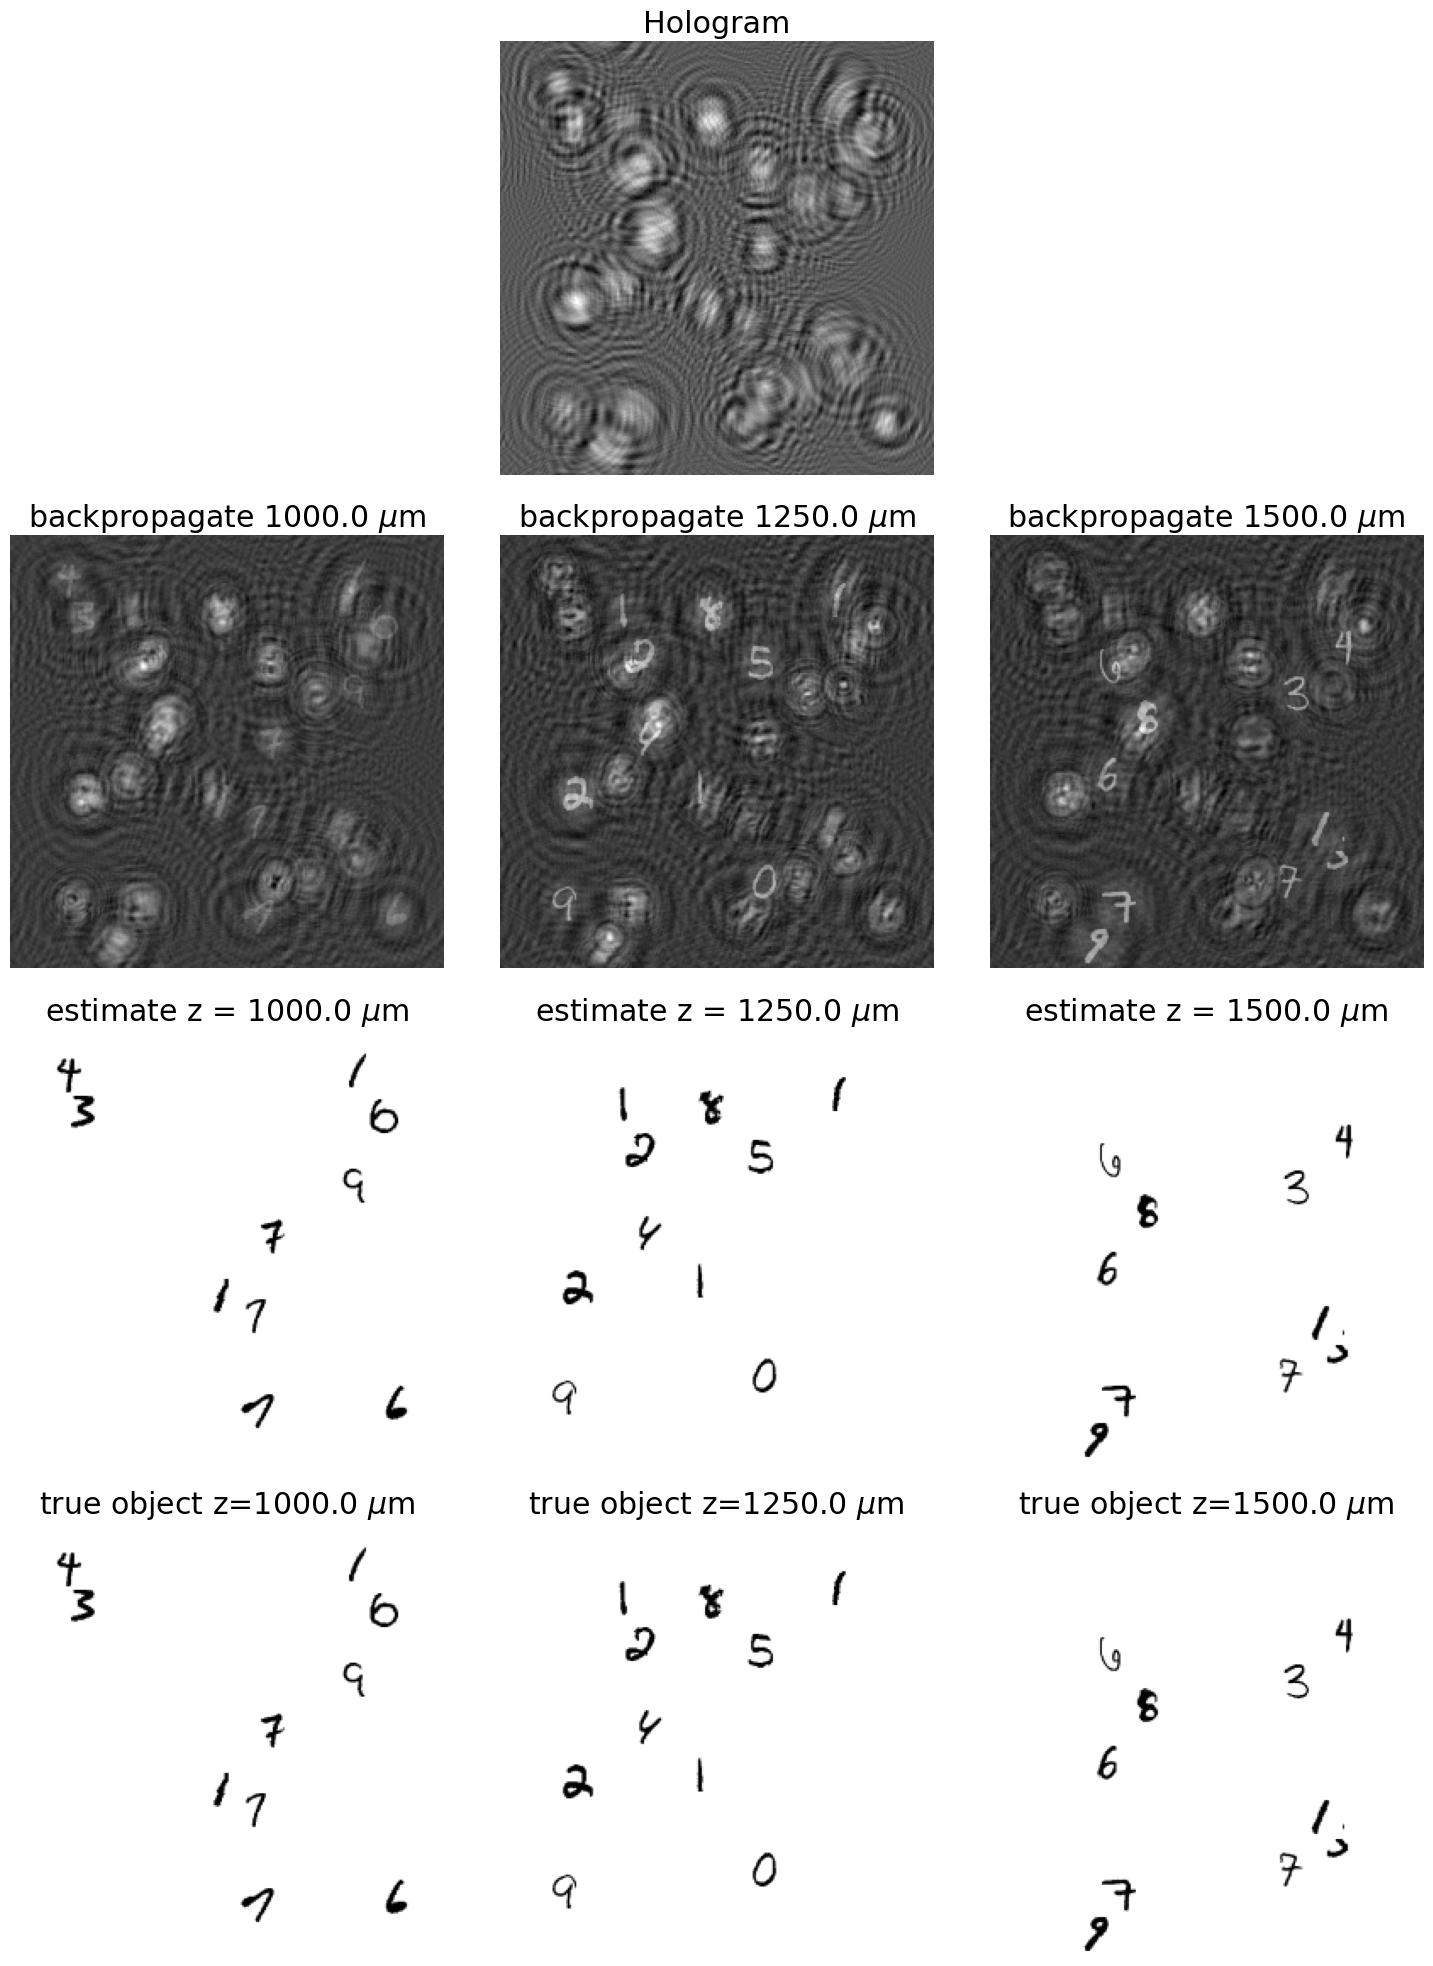

In [85]:
plt.figure(figsize=[15,20])
plt.subplot(4,3,2)
multi_obj_holo = Forward_Model(r, N, wavelength, pixel_pitch, single_depth=False)
hologram = multi_obj_holo.holo_multi_depth(input_field=input_field, z=z, z_pos_list=z, padding_size=0)
im = plt.imshow(hologram.cpu().detach().numpy()[0,0])
plt.axis('off')
plt.gray()
plt.title('Hologram')
divider = make_axes_locatable(plt.gca())
#cax = divider.append_axes("right", size="5%", pad=0.1)  
#plt.colorbar(im, cax=cax)

for i in range(len(z)):
    plt.subplot(4,3,4+i)
    f_est, CTF = multi_obj_holo.asm_custom(f=hologram, z_pos=-z[i], fix_padding=True, padding=0, crop2size=True)
    f_est = torch.abs(f_est)
#     f_est = f_est - torch.min(f_est)+0.
#     f_est = f_est/torch.max(f_est)
    im = plt.imshow(f_est.cpu().detach().numpy()[0,0])
    plt.axis('off')
    plt.title(f'backpropagate {z[i]} $\mu$m')
    divider = make_axes_locatable(plt.gca())
    #cax = divider.append_axes("right", size="5%", pad=0.1)
    #plt.colorbar(im, cax=cax)


for i in range(len(z)):
    plt.subplot(4,3,i+7)
    im = plt.imshow(abs(f_est_best[i]))
    plt.gray()
    plt.axis('off')
    plt.title(f'estimate z = {z[i]} $\mu$m')
    divider = make_axes_locatable(plt.gca())
  #  cax = divider.append_axes("right", size="5%", pad=0.1)
   # plt.colorbar(im, cax=cax)



for i in range(len(z)):
    plt.subplot(4,3,10+i)
    im = plt.imshow(abs(input_field[0,i,...].cpu().detach().numpy()))
    plt.axis('off')
    plt.title(f'true object z={z[i]} $\mu$m')
    divider = make_axes_locatable(plt.gca())
   # cax = divider.append_axes("right", size="5%", pad=0.1)  
   # plt.colorbar(im, cax=cax)
    plt.gray()    

plt.tight_layout()

plt.savefig('multiplaneCompressive.pdf')